# Artifact_Exploration
Looking at LED artifacts (are they electrical? photonic stimulation?) seen on Neuronexus recordings while shining an LED stimulus on an anesthetized, non-injected mouse.


Goal is to isolate potential artifacts so that we can find any *actual* spikes evoked in an injected mouse.

In [2]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from open_ephys.analysis import Session
from scipy import signal
from scipy.signal.windows import gaussian
import time
import ipympl
import os
%matplotlib ipympl
# from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
os.listdir('C:\\Users\\Kevin\\Documents\\data')

['2024-06-26_JZ_MZW_initialrecording',
 '2024-07-18_14-30-41',
 '2024-07-18_15-26-21_no_stim',
 '2024-07-18_15-39-46_stim',
 '2024-07-18_16-05-21_stim_50mA_0mm',
 '2024-07-18_16-11-30_stim_50mA_1mm',
 '2024-07-18_16-11-30_stim_50mA_1mm_full.png',
 '2024-07-18_16-11-30_stim_50mA_1mm_single_stim.png',
 '2024-07-18_16-13-02_stim_50mA_2mm',
 '2024-07-18_16-14-26_stim_50mA_3mm',
 '2024-07-18_16-15-22_stim_50mA_4mm',
 '2024-07-18_16-16-36_stim_50mA_5mm',
 '2024-07-18_16-17-48_stim_50mA_above',
 '2024-07-18_16-21-06_stim_20mA_0mm',
 '2024-07-18_16-23-56_stim_26mA_0mm',
 '2024-07-18_16-26-06_stim_26mA_above',
 '2024-07-18_16-49-58_stim_14mA_0mm_precision']

Load the data

In [4]:
# go through each directory
directory = 'C:\\Users\\Kevin\\Documents\\data\\2024-07-18_16-11-30_stim_50mA_1mm'

session = Session(directory)
print(session)


Open Ephys Recording Session Object
Directory: C:\Users\Kevin\Documents\data\2024-07-18_16-11-30_stim_50mA_1mm

<object>.recordnodes:
  Index 0: Record Node 101 (binary format)



Give an overview of the session -- recursively look through each of the sub-pieces

In [5]:
if session.recordnodes:
    print(f'recording contains recordnodes')
    print(f'{len(session.recordnodes[0].recordings)} recording(s) in session "{session.recordnodes[0].directory}"\n\n')
    recordings = session.recordnodes[0].recordings
else:
    print(f'recording does not contain recordnodes')
    print(f'{len(session.recordings)} recording(s) in session "{session.directory}"\n\n')
    recordings = session.recordings


for i_rec,recording in enumerate(recordings):
    recording.load_continuous()
    recording.load_spikes()
    recording.load_events()
    recording.load_messages()

    print(f'Recording {i_rec} has:')
    print(f'\t{len(recording.continuous)} continuous streams')
    print(f'\t{len(recording.spikes)} spike streams')
    print(f'\t{len(recording.events)} event streams')


recording contains recordnodes
1 recording(s) in session "C:\Users\Kevin\Documents\data\2024-07-18_16-11-30_stim_50mA_1mm\Record Node 101"


Recording 0 has:
	1 continuous streams
	0 spike streams
	320 event streams


In [ ]:
# session.recordings[0].continuous[0].metadata.keys()
# session.recordings[0].continuous[0].samples.shape
# session.recordings[0].info
recording.info['events'][0]['sample_rate']

# Plotting

Take a look at continuous streams without the events on top -- this is primarily for the "no stim" situation

In [ ]:
max_cont = 12
n_cont = session.recordings[0].continuous[0].samples.shape[1] 
n_cont = n_cont if n_cont < max_cont else max_cont

fig_cont, ax_cont = plt.subplots(nrows=n_cont, sharex=True, sharey=True)

timestamps = session.recordings[0].continuous[0].sample_numbers - session.recordings[0].continuous[0].sample_numbers[0]
timestamps = timestamps/session.recordings[0].continuous[0].metadata['sample_rate']
for i_cont in range(n_cont):
    # plot in volts
    values = session.recordings[0].continuous[0].samples[:,i_cont]*session.recordings[0].continuous[0].metadata['bit_volts'][i_cont]
    ax_cont[i_cont].plot(timestamps, values)

    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_cont[i_cont].spines[spine].set_visible(False)

    # make only bottom ticks visible
    if i_cont < (n_cont-1):
        ax_cont[i_cont].xaxis.set_visible(False)
    




take a look at the stimulation artifacts

Text(0.5, 0.98, '2024-07-18_16-11-30_stim_50mA_1mm')

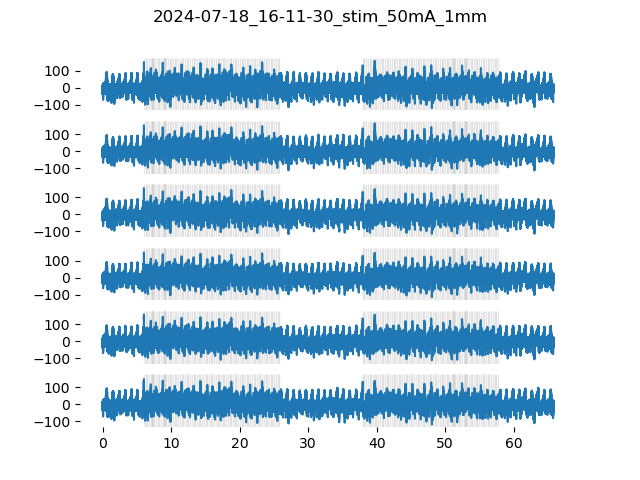

In [13]:
if session.recordnodes:
    recording = session.recordnodes[0].recordings[0]
else:
    recording = session.recordings[0]

max_cont = 6
n_cont = recording.continuous[0].samples.shape[1] 
n_cont = n_cont if n_cont < max_cont else max_cont

fig_event, ax_event = plt.subplots(nrows=n_cont, sharex=True, sharey=True)

# set up the events to plot patches
events = recording.events.sample_number.values - recording.continuous[0].sample_numbers[0] # to make sure we're starting at the same point
events = events/recording.info['events'][0]['sample_rate']
events = events.reshape([int(events.shape[0]/2),2])
# event_vertical = [recording.continuous[0].samples.max()* recording.continuous[0].metadata['bit_volts'][i_cont], recording.continuous[0].samples.min()* recording.continuous[0].metadata['bit_volts'][i_cont]] 

timestamps = recording.continuous[0].sample_numbers - recording.continuous[0].sample_numbers[0]
timestamps = timestamps/recording.continuous[0].metadata['sample_rate']
for i_cont in range(n_cont):
    # plot in volts
    values = recording.continuous[0].samples[:,i_cont]*recording.continuous[0].metadata['bit_volts'][i_cont]
    ax_event[i_cont].plot(timestamps, values)

    # plot the event times
    for i_event,event in enumerate(events):
        # print(f'{i_event}:{event}')
        ax_event[i_cont].axvspan(event[0], event[1], color='k', alpha=.1)

    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_event[i_cont].spines[spine].set_visible(False)

    # make only bottom ticks visible
    if i_cont < (n_cont-1):
        ax_event[i_cont].xaxis.set_visible(False)

fig_event.suptitle(os.path.split(directory)[-1])

Let's look at the spectrogram and the power spectrum for the signal

Text(0.5, 0, 'Time $t$ in seconds')

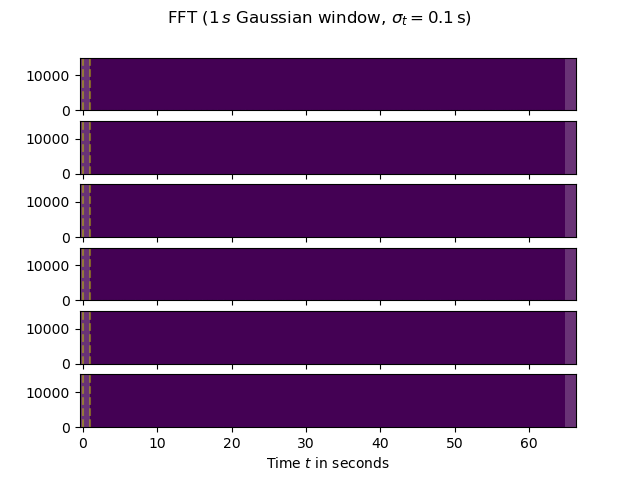

In [23]:
# len_gauss = 1024
# std = 128
# hop=128
len_gauss = 30000
std = 300
hop = 300

window = gaussian(len_gauss, std, sym=True)
fs = recording.continuous[0].metadata['sample_rate']
fft = signal.ShortTimeFFT(window, hop=hop, fs=fs, scale_to='magnitude')

if session.recordnodes:
    recording = session.recordnodes[0].recordings[0]
else:
    recording = session.recordings[0]

# number of signals etc
max_cont = 6
n_cont = recording.continuous[0].samples.shape[1] 
n_cont = n_cont if n_cont <= max_cont else max_cont

# length of the recording -- cleans up the code
n_samples = recording.continuous[0].samples.shape[0] 

# start a fft with a subplot for each continuous signal plotted
fig_fft, ax_fft = plt.subplots(nrows=n_cont, sharex=True, sharey=True)

fig_fft.suptitle(rf"FFT ({fft.m_num*fft.T:g}$\,s$ Gaussian window, " +
                 rf"$\sigma_t={std*fft.T}\,$s)")

for i_cont in range(n_cont):
    values = recording.continuous[0].samples[:,i_cont]*recording.continuous[0].metadata['bit_volts'][i_cont]
    Sx = fft.stft(values)
    
    # time range of the plot
    t_lo, t_hi = fft.extent(n_samples)[:2]

    # plot the spectrogram
    ax_fft[i_cont].imshow(abs(Sx[:]), origin='lower', aspect='auto',
                          extent=fft.extent(n_samples), cmap='viridis')
    
    # shade areas where slice stick outside of the signal
    for t0_, t1_ in [(t_lo, fft.lower_border_end[0] * fft.T), (fft.upper_border_begin(n_samples)[0] * fft.T, t_hi)]:
        ax_fft[i_cont].axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

    # and mark the borders with a vertical line:
    for t_ in [0, fs*fft.T]:
        ax_fft[i_cont].axvline(t_, color='y', linestyle='--', alpha=0.5)

    # make only bottom ticks visible
    if i_cont < (n_cont-1):
        ax_event[i_cont].xaxis.set_visible(False)

    # clean everything out
    ax_fft[i_cont].set(xlim=(t_lo, t_hi))
    
    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_event[i_cont].spines[spine].set_visible(False)

# set up the labels on the bottom axis
ax_fft[-1].set_xlabel(f'Time $t$ in seconds')


In [20]:
fft.extent(recording.continuous[0].samples.shape[0])

(-0.0128, 65.8048, 0.0, 15029.296875)